<a href="https://colab.research.google.com/github/RepnaiaE/DataScience_functional-state-analysis/blob/main/EEG_signal_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Лабораторная работа №3
## Обработка сигнала ЭЭГ с использованием библиотеки MNE/EEG signal processing using the MNE library


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


***MNE-Python*** - это пакет Python с открытым исходным кодом для изучения, визуализации и анализа нейрофизиологических сигналов человека, таких как МЭГ, ЭЭГ, электрокортикограммы (ECoG) и других. Он включает в себя модули для ввода/вывода данных, предварительной обработки, визуализации, частотно-временного анализа, анализа связности, машинного обучения и статистики.<br/>
С официальной документацией можно ознакомиться по ссылке: http://mne.tools/stable/

In [ ]:
!pip install mne
!pip3 install -U matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.6 MB 5.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.4 MB 5.1 MB/s 
     |████████████████████████████████| 295 kB 41.3 MB/s 
     |████████████████████████████████| 965 kB 56.8 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


In [ ]:
import mne
from mne import create_info, find_events, Epochs, EpochsArray, set_eeg_reference
import numpy as np

<h4><b>Основные структуры данных и стандартный рабочий процесс MNE-Python при анализе данных ЭЭГ</b></h4>

К основным структурам данных в MNE-Python относятся `Raw`, `Epochs` и `Evoked`. <br/>
Непрерывные необработанные данные хранятся в экземплярах класса `Raw`. Это основной формат представления сырых данных, к которому применимы определенные методы предобработки (фильтрация, подавление шумов, визуальное исследование данных).<br/>Исходные данные могут быть сегментированы на определенные временные промежутки одинаковой длины, называемые <i>эпохами</i> (<i>Epoch</i>) или испытаниями (<i>trials</i>), которые обычно соответствуют сегментам данных, связанных с интересующем исследователя событием, например, визуальным стимулом или реакцией испытуемого. Иногда могут извлекаться последовательные или перекрывающиеся эпохи (например, при анализе активности в состоянии покоя). Длительность эпохи определяется произвольно в зависимости от экспериментальной парадигмы и обычно составляет от 500 мс до 2 с. <br/>
Эпохи различных экспериментальных условий, полученные от одного испытуемого, в MNE-Python хранятся в экземпляре класса `Epochs`. Для создания объекта `Epochs` с помощью конструктора класса необходимо указать экземпляр класса `Raw` и массив событий, определить временное окно (время относительно каждого события, в которое начинается и заканчивается каждая эпоха). Также можно определить условия отклонения отдельных эпох с помощью задания пороговых значений амплитуды сигнала. <br/>
Эпохи могут быть усреднены для формирования вызванных потенциалов, связанных с событиями. <i>Потенциал, связанный с событием</i> (англ. <i>event-related potential - ERP</i>) - это измеренный отклик мозга, формируемый в ответ на любое сенсорное, когнитивное или двигательное явление, дугими словами, это любой стереотипный электрофизиологический ответ на раздражитель. К подтипам ERP относятся вызванные и индуцированные потенциалы.<br/>
Усредненные данные хранятся в экземплярах класса `Evoked`, которые могут быть созданы простым вызовом метода `average` на экземпляре класса `Epochs`.<br/>
Все перечисленные структуры данных имеют некоторые общие атрибуты, такие как `ch_names`, который представляет собой список Pithon, содержащий название всех каналов, и атрибут `info`, представляющий собой модифицированный словарь Pithon, в котором хранятся все метаданные о записях. Этот атрибут часто называют <i>измерительной информацией</i>. Ключи `info` ограничены теми, которые предусмотрены спецификацией формата FIF. Метаданные включают информацию о частоте дискретизации (`info['sfreq']`), типах и названии каналов (`info['chs']`), список плохих каналов (`info['bads']`) и др.  Атрибут `info` может быть использован для удобного выбора каналов по типу или названию при обработке и анализе данных.

<h4><b>Загрузка файлов ЭЭГ некоторых распространенных форматов</b></h4>

<p>Структуры данных MNE-Python основаны на формате файла FIF от Neuromag. Но библиотека включает в себя функции и утилиты для чтения широкого спектра других форматов данных, таких как BTI/4D, KIT, EDF, Biosemi BDF и BrainVision EEG.<br/>
<i>EDF/EDF+</i> (<i>Европейский формат данных</i>) - общепринятый формат данных для хранения биоэлектрических сигналов, таких как электрокардиограмма, электроэнцефалограмма, электромиограмма. Многие программные продукты поддерживают запись/экспорт данных в EDF формат. Существуют также специальные браузеры для просмотра EDF-файлов, доступные бесплатно.
Подробнее о данном формате: https://edfplus.info/<br/>


Использовались файлы из датасета https://archive.physionet.org/physiobank/database/eegmat/.

In [ ]:
raw = mne.io.read_raw_edf('/content/drive/MyDrive/ИТМО/Функциональные состояния/Lab3/Subject35_1.edf',  preload=True)

Extracting EDF parameters from /content/drive/MyDrive/ИТМО/Функциональные состояния/Lab3/Subject35_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...


В дополнение к информации, отображаемой во время загрузки, получить представление об основных деталях необработанного объекта можно с помощью функции `print`, применив ее к самой записи и к атрибуту `info`. `Info` отслеживает расположение каналов, применяемые фильтры, линейные операции и т.д., эта информация сохраняется и в `Raw`, и в `Epochs` и в`Evoked`. Если исследуемая запись включает данные с разных датчиков, В строке `chs`могут быть указаны разные типы каналов, что говорит о том, что MNE-Python распознает различные типы датчиков и обрабатывает каждый из них соответствующим образом.

In [ ]:
print(raw) # вместо raw указывается название соответствующей переменной с данными (rec1, rec2 или  rec3)
print(raw.info.ch_names) # метаданные записи

<RawEDF | Subject35_1.edf, 21 x 91000 (182.0 s), ~14.6 MB, data loaded>
['EEG Fp1', 'EEG Fp2', 'EEG F3', 'EEG F4', 'EEG F7', 'EEG F8', 'EEG T3', 'EEG T4', 'EEG C3', 'EEG C4', 'EEG T5', 'EEG T6', 'EEG P3', 'EEG P4', 'EEG O1', 'EEG O2', 'EEG Fz', 'EEG Cz', 'EEG Pz', 'EEG A2-A1', 'ECG ECG']


<h4><b>Предобработка</b></h4>
<p>Основная цель предобработки данных (англ. <i>preprocessing</i>) заключается в преобразовании необработанных данных в формат, более подходящий для дальнейшей обработки и анализа. MNE-Python поддерживает различные подходы и методы предварительной обработки (различные типы фильтрация и методы коррекции артефактов, проекция пространства сигналов, понижение частоты дискретизация и др.). С полным списком возможностей можно ознакомиться в справке по подмодулях <code>mne.preprocessing</code> и <code>mne.filter</code>. Выбор конкретных способов преобразования зависит от исходных данных и целей исследования.</p>

<h5>Установка схемы монтажа</h5>
<p>Некоторые форматы ЭЭГ (EGI, EDF / EDF +, BDF) не содержат данных о расположении электродов. Поэтому эту информацию нужно предоставлять отдельно, она может помочь в дальнейшем анализе. Монтаж определяет название каналов ЭЭГ и их относительное расположение на поверхности головы, также может содержать информацию о расположении реперных и других дополнительных точек. <br/>
MNE содержит несколько встроенных типов монтажа, соответствующих принятым международным системам расположения электродов, а также схемам, используемым в специальном оборудовании, широко применяемом для научных исследований.
Для этой цели все необработанные экземпляры имеют метод <code>mne.io.Raw.set_montage()</code> для установки местоположения электродов.
Указание схемы монтажа необязательно, но открывает некоторые дополнительные полезные опции при анализе данных, например, позволяет реконструировать и визуализировать расположение сенсоров, различать сигналы с разных каналов.</p>

<h5>Переименование каналов</h5>
<p>В стандартных схемах монтажа библиотеки MNE в названиях каналов используются только заглавные буквы (FC4, CP4 и т.д.). Если в рассматриваемой записи названия каналов прописаны строчными буквами, при применении стандартной схемы монтажа (метод set_montage()) появится сообщение об ошибке, что таких каналов не существует. В этом случае можно воспользоваться следующей функцией для переименования каналов, чтобы привести их в соответстветствие названиям стандартного набора.</p>

In [ ]:
def renamer(raw):
    ch_names = raw.info.ch_names
    ch_names = [ch.split(" ")[1] for ch in ch_names]
    a = raw.ch_names
    newch ={}
    for i in range(len(a)):
        ch = {a[i]:ch_names[i]}
        newch.update(ch)

    raw.rename_channels(newch)
    raw.drop_channels(["A2-A1", "ECG"])

    return raw

raw = renamer(raw)

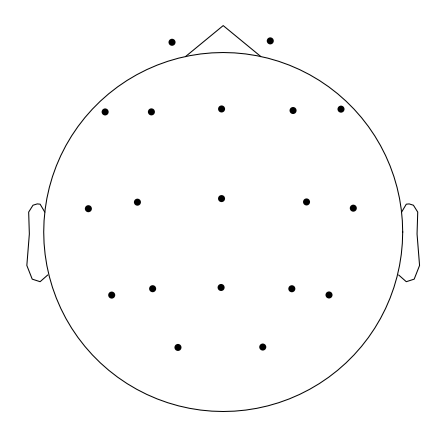

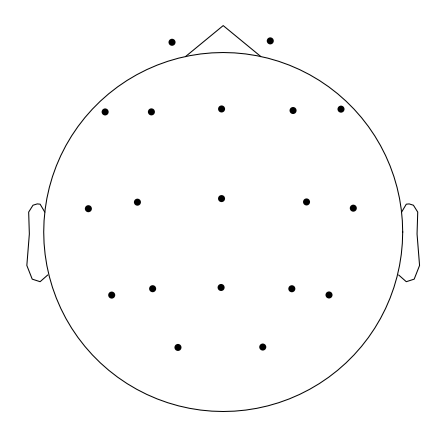

In [ ]:
### определяем схему монтажа, входные параметры: тип монтажа, размер головы (радиус в метрах, по умолчанию 95 мм)
montage = mne.channels.make_standard_montage('standard_1020') # расположение электродов в соответствии с международной системой 10-20
### установить монтаж
raw.set_montage(montage)
### визуализация схемы монтажа
raw.plot_sensors()

<h5>Визуализальный анализ данных/Visual Data Analysis
</h5>



<p>Визуализальный анализ данных позволяет провести первичную оценку записи, выявить плохие каналы и участки с артефактами. Для визуализации необработанных данных используется метод <code>plot()</code>.<br/>
Параметр <code>duration</code> задает временное окно (в секундах) для построения графика. Если продолжительность записи не совпадает с указанным интервалом, будет использовано меньшее из этих значений.<br/>
Параметр <code>n_channels</code> определяет количество каналов для отображения (по умолчанию - 20).<br/>
Метод также имеет множество параметров для настройки визуализации данных. Для использования всех возможностей визуализации рекомендуется использовать интерактивный режим <code>matplotlib</code>, который позволяет прокручивать графики, масштабировать, маркировать плохие каналы, аннотировать каналы и т.д.<br/>
Клавиши со стрелками (вверх / вниз / влево / вправо) используются для навигации между каналами и временными диапазонами. Масштабирование можно настроить с помощью клавиш "-" и "+" (или "="). Для регулирования размеров области просмотра используются клавиши Page Up/Page Down и Home/End.<br/>
Чтобы пометить канал как плохой или снять с него такую отметку, достаточно щелкнуть по метке канала или по изображению сигнала с данного канала. При этом изменения будут немедленно отражены в записи raw.info ['bads'].Полный список команд для управления визуализацией данных можно посмотреть, щелкнув по кнопке "Help" в левом нижнем углу.<br/><br/>
Метод <code>plot_psd()</code> предназнечен для отображения спектральной плотности мощности сигнала по каналам. Метод также имеет множество входных аргументов, позволяющих ограничить диапазон рассматриваемых частот и временной промежуток, задать некоторые параметры вычисления преобразования Фурье и отображения графика.</p>






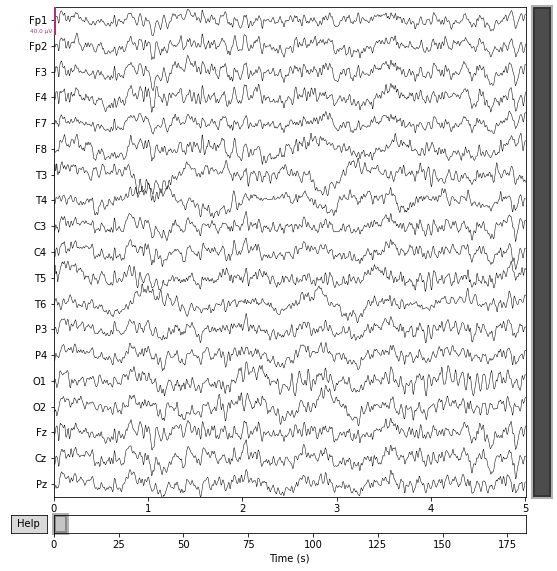

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 4.096 (s)


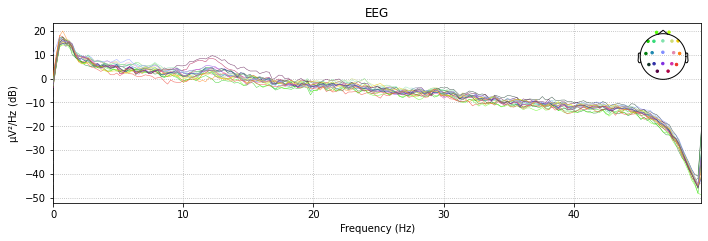

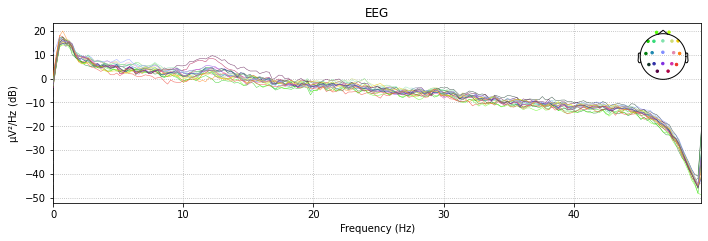

In [ ]:
raw.plot(duration=5, n_channels=30) # визуализация необработанных данных
raw.plot_psd(fmax=50) # спектральная плотность мощности (ограничиваемся частотами до 50 Гц)

<h5>Интерполяция данных/Data Interpolation
</h5>
<p>При отсутствии данных по одному из каналов MNE позволяет интерполировать недостающий сигнал по информации из соседних каналов./If there is no data on one of the channels, the MNE allows you to interpolate the missing signal from information from adjacent channels.</p>

In [ ]:
### интерполяция плохих каналов
raw.interpolate_bads(reset_bads=True, mode='accurate')

<ipython-input-60-09201c5111aa>:2: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw.interpolate_bads(reset_bads=True, mode='accurate')


<RawEDF | Subject35_1.edf, 19 x 91000 (182.0 s), ~13.2 MB, data loaded>

<h5>Пространственная фильтрация (пересчет референца)/
Spatial filtering (reference recalculation)</h5>

*Ремонтаж* (англ. *remonage*, *re-referencing*, *reformatting*) – изменение референса уже после проведения записи. Идея ремонтажа заключается в том, чтобы выразить напряжение в каналах ЭЭГ по отношению к другому, новому эталону, что может способствовать, например, уменьшению шума или увеличению амплитуды для более оптимального отображения активности мозга при интерпретации сигнала.<br/>
Часто в качестве схемы ремонтажа используется *общий усредненный референтный монтаж* (*Common Average Reference*, *CAR*). Это монтаж, при котором потенциалы электродов измеряются относительно общего усредненного референта, т.е. потенциала, полученного при усреднении значений, зарегистрированных со всех электродов. Такой пересчет референца позволяет невелировать разную удаленность активных электродов от референтного.

In [ ]:
# расчет среднего референца по всем каналам
mne.set_eeg_reference(raw)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


(<RawEDF | Subject35_1.edf, 19 x 91000 (182.0 s), ~13.2 MB, data loaded>,
 array([-3.15532948e-06, -2.86912800e-06, -2.52450656e-06, ...,
        -7.12704332e-10, -7.12704332e-10, -7.12704332e-10]))

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1651 samples (3.302 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 4.096 (s)


[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.3s finished


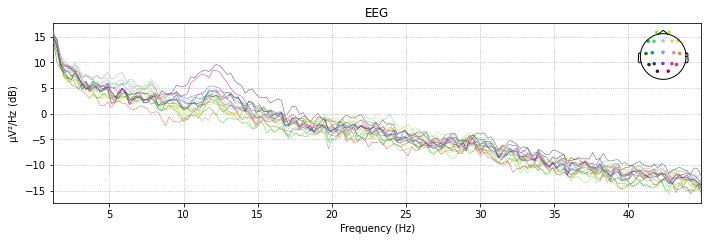

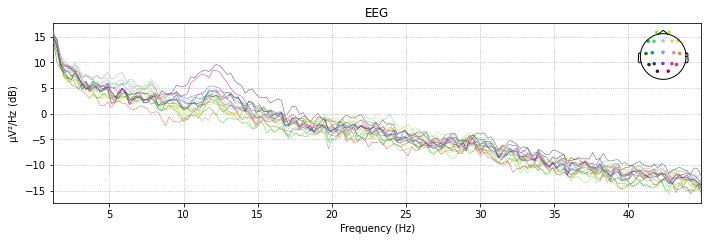

In [ ]:
### частотная фильтрация (выделение диапазона исследования)
raw.filter(1, 45, fir_design='firwin', skip_by_annotation='edge')
raw.plot_psd(fmin=1, fmax=45)

<h4><b>Детектирование экспериментальных событий/
Detection of experimental events</b></h4>

Наборы данных могут содержать один или несколько триггер-каналов (trigger channel или stim channel), используемых для кодирования событий во время записи ЭЭГ. Как правило, сигнал в таком канале равен нулю и принимает положительные значения при наступлении некоторого события (начало стимула или реакция испытуемого). Такие каналы часто имеют префикс 'STI', чтобы отличать их от других типов каналов.<br/>
Функция `mne.find_events` осуществляет поиск событий в данных на основе значений триггер-канала. Если используется несколько триггерных каналов, то возвращаемые события будут объединением всех событий, извлеченных из отдельных каналов. Результирующий массив событий представляет собой обычный массив NumPy, в котором первый столбец содержит время наступления события (номер выборки), третий столбец - целочисленный идентификатор события, средний столбец обычно игнорируется. <br/>
Если указать `initial_event=True` (по умолчанию False), то событие создается, если триггер-канал имеет значение, отличное от 0 в качестве первого экземпляра. Это полезно, если присутствует событие в момент времени t = 0 с.<br/>
Вместо того чтобы отслеживать целочисленные идентификаторы событий, для удобства последующего анализа можно составить словарь событий, сопоставляющий целочисленные идентификаторы с экспериментальными событиями.

Выбранные данные не содержат каналов с метками, поэтому код ниже не выполнялся.

In [ ]:
events = mne.find_events(raw, initial_event=True)
ids = {'motor':1, 'rest': 4}

ValueError: ignored

Помимо наличия триггерных каналов исходные данные могут содержать метки, которые можно достать из аннотаций, и на их основе детектировать события.

In [ ]:
events, ids = mne.events_from_annotations(raw)

Для исследований, которые не связаны с событиями (например, при анализе данных состояния покоя), можно создать события с помощью функции <code>mne.make_fixed_length_events</code>, которая извлекает равноотстоящие друг от друга (возможно, перекрывающиеся) промежутки данных, и далее их использовать для эпохинга непрерывных данных.<br/>
Параметр <code>duration</code> задает временной период для разделения событий, а <code>overlap</code> - перекрытие между событиями (<code>0 <= overlap < duration</code>).

In [ ]:
events = mne.make_fixed_length_events(raw, duration=2.0, id=1)

<h4><b>Разделение данных на эпохи/Splitting data into epochs</b></h4>

Массив и словарь событий используются для извлечения эпох из непрерывных данных. Также требуется задать временное окно, указав время начала (tmin) и окончания (tmax) каждой эпохи, которые рассчитываются относительно связанного с ней события.<br/>
При извлечении эпох можно одновременно ввести ограничения на качество данных, сразу отбрасывая эпохи, у которых амплитуда сигнала выходит за разумные пределы для данного типа канала. Это можно сделать с помощью словаря отклонений, указав в нем пороговые значения для всех типов каналов, присутствующих в данных, и передав его в качестве значения параметра <code>reject</code>. Однако такие значения должны подбираться отдельно для каждого конкретного набора данных, в зависимости от используемых  аппаратных средств и условий записи.

In [ ]:
epochs = mne.Epochs(raw, events, event_id=1, tmin=-0.2, tmax=0.5, preload=True)

Not setting metadata
91 matching events found
Setting baseline interval to [-0.2, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 91 events and 351 original time points ...
1 bad epochs dropped


Как объекты `Raw`, так и `Epochs` имеют метод `get_data`, который возвращает исходные данные в виде массива NumPy. Оба метода имеют параметр `picks` для выбора определенного канала (каналов), `raw.get_data()` имеет дополнительные параметры для ограничения временной области. Результирующие матрицы имеют размерность (`n_channels`, `n_times`) для `Raw` и (`n_epochs`, `n_channels`, `n_times`) для `Epochs`.

In [ ]:
DATA=raw.get_data()

<h4><b>Оценка вызванных реакций/Estimation of evoked reactions</b></h5>

После выявления эпох, связанных с событиями, можно получить оценку вызванных реакций на стимулы, вычислив среднее значение по эпохам. <br/>
Более детальное представление об объекте `Evoked` можно получить с помощью методов визуализации, таких как `plot_joint` и `plot_topomap`.<br/>
`plot_topomap` строит топографические карты вызванных потенциалов в конкретных временных точках. Эти моменты времени могут быть заданы вручную или определены автоматически.<br/>
`plot_joint` изображает вызванные потенциалы в виде графика бабочки и добавляет топографические карты для временных точек.

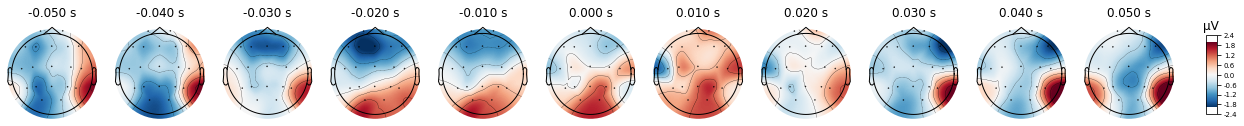

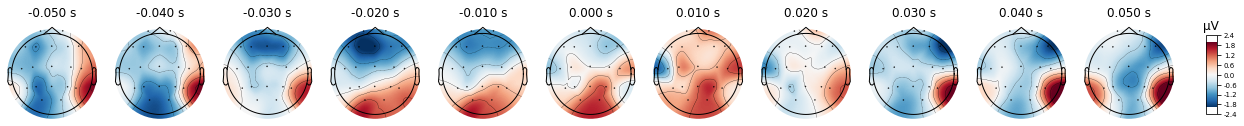

In [ ]:
evoked = epochs.average()
evoked.plot_topomap(times=np.linspace(-0.05, 0.05, 11))

<h4><b>Обнаружение и удаление артефактов/Artifact detection and removal</b></h4>

На ЭЭГ практически всегда присутствуют сигналы, которые не связаны с активностью головного мозга, а происходят от других источников. Такие сигналы называют *артефактами*. Таким образом, артефакты являются формой помех или шума относительно интересующего полезного сигнала. Причины возникновения таких помех могут иметь как физическую, так и физиологическую природу. Наиболее часто встречаются следующие типы артефактов:


*   артефакты, вызванные движением глаз (включая глазное яблоко, глазные мышцы и веко);
*   артефакты от ЭКГ;
*   артефакты от ЭМГ;
*   артефакты, вызванные движением языка и мышечной активностью во время глотания.

В некоторых случаях сигналы мозговой деятельности также могут являться артефактами. Например, если исследуется сенсорная реакция на стимул, однако экспериментальная парадигма включает некоторую поведенческую реакцию (например, нажатие кнопки), тогда нейронная активность, связанная с планированием и выполнением нажатия на кнопку, может рассматриваться как артефакт по отношению к интересующему сигналу (например, вызванном сенсорном ответе).<br/>
Необходимо также помнить, что артефакты одного и того же происхождения могут по-разному выглядеть на записях, сделанных разными системами ЭЭГ или МЭГ, из-за различий в конструкции датчиков (например, при использовании пассивных и активных электродов ЭЭГ).<br/>
Возможны 3 основных варианта действий при обнаружении артефактов в записях:


*   игнорировать артефакт и продолжить анализ;
*   исключить поврежденную часть данных и анализировать оставшиеся данные;
*   восстановить сигнал, подавив артефактную часть записи, при этом оставив интересующий сигнал нетронутым.

Существует множество различных подходов к избавлению полезного сигнала от артефактов. MNE-Python предоставляет для этого множество инструментов, включая цифровую фильтрацию, анализ независимых компонент (ICA), фильтрацию Максвелла и другие.

<h4>Обнаружение артефактов</h4>

Большинство артефактов на ЭЭГ легко определяются визуальным путем. К таким артефактам относятся, например, сетевая наводка, дрейф изолинии в одном из каналов из-за плохо установленного электрода, медленные волны, вызываемые движением глаз и др.
Низкочастотные дрейфы проще всего обнаружить при визуальном осмотре с использованием основного метода <code>plot()</code>, при этом рекомендуется строить график за относительно большой промежуток времени и не использовать поканальную коррекцию сдвига постоянного тока. Устраняются низкочастотные дрейфы  с помощью высокочастотных фильтров с достаточно низкой частотой среза. Например, при длине волны дрейфа около 20 срез 0,1 Гц позволяет подавить большую часть дрейфа.<br/>
Сетевая наводка от сети переменного тока в современных энцефалографах встречается редко. Причиной ее появления являются помехи от электрических полей, создаваемых устройствами передачи и эксплуатации промышленного электрического тока, например, медицинской аппаратуры, а также неисправность аппаратуры. Шум сетевой наводки проще всего обнаружить по графикам спектральной мощности (метод <code>plot_psd()</code>), при этом необходимо учитывать, что в России частота линии элетропередачи составляет 50 Гц, а в США - 60 Гц. Для устранения сетевой наводки необходимо отрегулировать энцефалограф, проверить наличие заземления аппаратуры, нарушение контакта в электродных проводниках, рекомендуется на короткое время выключить все электроприборы. Для подавления артефактов, вызванных помехами от электрических полей применяют фильтр высоких частот. <br/>
Резкие скачки потенциала с зашкаливанием могут свидетельствовать об обрыве соединительного провода, плохой установке электрода, поляризация электрода или о накоплении электрических зарядов на теле испытуемого. В таких случаях необходимо проверить целостность проводов, соединяющих электрод с входной коробкой электроэнцефалографа, правильность коммутации. При появлении потенциала поляризации необходимо заменить электрод. <br/>

MNE-Python включает несколько инструментов для автоматического обнаружения определенных артефактов (таких как сердцебиение и моргание), при этом остается возможность визуально проверить данные, чтобы идентифицировать и аннотировать артефакты. Например, для обнаружения и извлечения артефактов, связанных с сердцебиением, в MNE существуют специальные функции ```find_ecg_events()``` и ```create_ecg_epochs()``` из подмодуля ```preprocessing```. С примерами их использования можно ознакомиться в официальной документации.


<h4>Артефакты, вызванные движением глаз (ЭОГ)/Eye Movement Artifacts (EOG)</h4>

<p>Глазодвигательные артефакты (электроокулограммы) являются одними из наиболее распространенных артефактов при записи ЭЭГ. Они проявляются в виде медленноволновых колебаний частотой 0,3- 2 Гц, особенно ярко выраженных во фронтальных предлобных каналах, находящихся непосредственно над глазами (FP1/2). Электроокулограмма (ЭОГ) генерируется электрическими потенциалами, вызванными вертикальными движениями глаз. Артефакты ЭОГ не связаны с текущей ритмикой на ЭЭГ и возникают независимо от ее изменений. Генерируемый потенциал имеет более высокую амплитуду (исчисляемую в мВ) по сравнению с амплитудой колебаний, генерируемых головным мозгом (исчисляемой в мкВ). В этой связи, определенные сложности могут возникнуть при дифференциальной диагностики ЭОГ с медленноволновой активностью глубинных отделов лобных долей головного мозга, поскольку глазодвигательный артефакт накладывается на медленноволнововую активность, маскируя ее. Однако отличительной особенностью ЭОГ является пространственное распределение. Для окулограммы характерно затухание амплитуды от лобных отведений по направлению к затылочным, симметричность и стереотипная форма потенциалов. Сохранение высокоамплитудных медленных волн в лобных и центральных отведениях позволяет предположить наличие объемного процесса в глубинных отделах лобных долей.<br/>Также при возникновении сложностей дифференциальной диагностики окулограммы от биоэлектрической активности головного мозга рекомендуется использовать дополнительные электроды, расположенные по окружности глаз. Электроды, расположенные над и под глазами, помогают отличить, является ли генератором активности головной мозг или эта активность представляет собой артефакт, вызванный вертикальными движениями глаз. В первом случае наблюдается одинаковая полярность на каждом из электродов, во втором - противоположная полярность на электродах, расположенных над и под глазом. Горизонтальное расположение дполонительных электродов позволяет зарегистрировать ЭОГ горизонтальных движений глаз. </p>

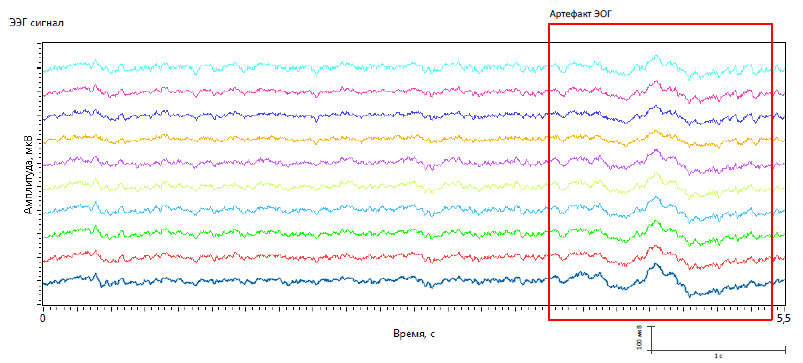

MNE-Python включает специальные функции для обнаружения и извлечения глазодвигательных артефактов. Функция ```find_eog_events()``` позволяет обнаруживать артефакты, связанные с движением глаз. Функция ```create_eog_epochs()``` фильтрует данные, находит пики морганий в данных EOG, автоматически вызывая ```find_eog_events()```, и использует полученный массив событий для извлечения эпох, сосредоточенных вокруг обнаруженных артефактов. Таким образом, данная функция является функцией более высокого уровня, позволяя автоматически находить артефакты и генерировать вокруг них эпохи за один шаг. Обязательными параметрами функции являются название записи с данными и название канала, используемого для обнаружения артефактов (аргумент является обязательным, если набор данных не содержит выделенных каналов EOG). Также можно задать частотный и временной диапазон для поиска артефактов, параметры подавления и другие настройки.<br/>
<u>Примечание.</u> В стандартных схемах монтажа ближе всего ко лбу находятся каналы 'Fp1' и 'Fp2', как правило, в них сильнее всего выражены моргания, поэтому в них в первую очередь следует детектировать глазодвигательные артефакты.

In [ ]:
eog_epochs = mne.preprocessing.create_eog_epochs(raw, ch_name='Fp1') # генерируем эпохи, связанные с ЭОГ

Using EOG channel: Fp1
EOG channel index for this subject is: [0]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 sec)

Now detecting blinks and generating corresponding events
Found 245 significant peaks
Number of EOG events detected: 245
Not setting metadata
245 matching events found
No baseline correction applied
Using data from preloaded Raw for 245 events and 501 original time points ...
1 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Как и объекты `Raw`, объекты класса `Epochs` имеют ряд встроенных методов для построения графиков, которые можно использовать для визуализации обнаруженных артефактов.<br/>
Метод `plot_image` отображает каждую эпоху как отдельную строку карты изображения, причем цвет соответствует величине сигнала; под изображением отображается график среднего вызванного отклика по артефактам. Параметр `combine` задает, как объединяется информация по каналам.<br/>

Not setting metadata
244 matching events found
No baseline correction applied
0 projection items activated
combining channels using "mean"


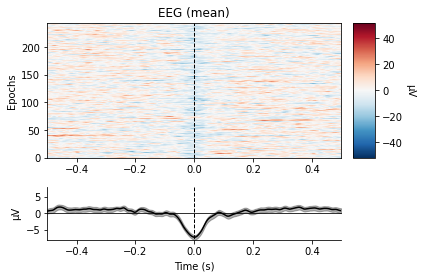

No projector specified for this dataset. Please consider the method self.add_proj.


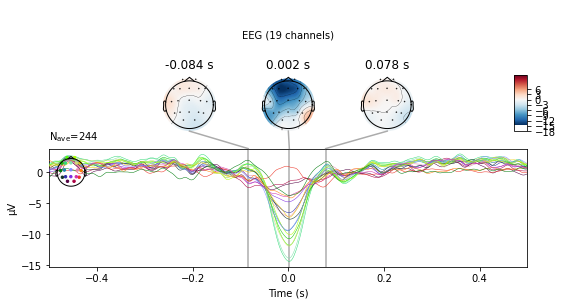

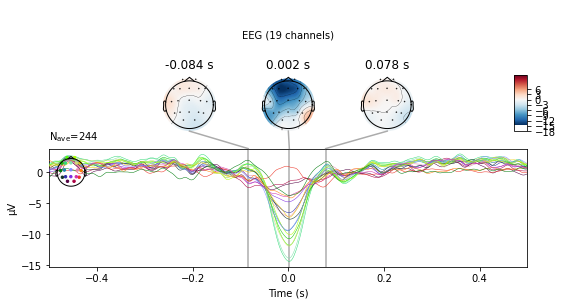

In [ ]:
# карта изображения эпох с графиком среднего ERP по артефактам
eog_epochs.plot_image(combine='mean')

# нижний график отображает усредненные артефакты по каждому каналу
# топографическая карта показывает, в какой части головы наиболее выражена их амплитуда
eog_epochs.average().plot_joint()

<n5><b>Метод независимых компонент (ICA)/Method of independent components (ICA)</b></h5>

Присутствие артефакта, связанного с вертикальными моргательными движениями глаз, помогает определить состояние бодрствования испытуемого. В состоянии дремоты медленные вращательные движения глаз также могут оказывать диагностическую помощь. Такие движения глаз обычно легко распознать, так как на поверхностной ЭЭГ они создают реверсию фазы в передних височных отведениях с противоположной полярностью на противоположной стороне. Однако в ряде случаев, например, при исследовании вызванных потенциалов, требуется корректировка глазодвигательных артефактов.<br/>
Метод независимых компонент широко применяется для удаления глазодвигательных (моргательных) артефактов. Суть метода заключается в разделении многокомпонентного сигнала ЭЭГ, на который накладываются артефакты и шумы, на обособленные составляющие, независимые друг от друга. Поскольку моргания происходят независимо от основной мозговой деятельности, ICA позволяет выделить глазодвигательные артефакты, накладываемые на основной сигнал ЭЭГ.<br/>

Важным шагом перед применением ICA является фильтрация данных от низкочастотных дрейфов, которые могут негативно повлиять на точность решения. Рекомендуется использовать фильтр высоких частот с частотой среза 1 Гц.

In [ ]:
filt_raw = raw.copy()
filt_raw.load_data().filter(l_freq=1., h_freq=None)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1651 samples (3.302 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.1s finished


<RawEDF | Subject35_1.edf, 19 x 91000 (182.0 s), ~13.2 MB, data loaded>

В MNE-Python реализация метода ICA находится в модуле `preprocessing`. Метод имеет несколько входных аргументов, наиболее важным из которых является количество компонент (`n_components`), от которого зависят точность и скорость работы алгоритма. При сильной выраженности глазодвигательных артефактов (об этом можно судить по визуальному анализу необработанных данных) можно ожидать, что эти артефакты будут зафиксированы в нескольких первых измерениях декомпозиции сигнала методом главных компонент (PCA), который всегда производится до ICA. Компоненты располагаются по степени выраженности, т.е. по степени влияния на сигнал, и, как правило, моргательные артефакты детектируются в первых компонентах. Однако для более точного результата рекомендуется включать больше компонент. В этом случае следует помнить, что количество компонент не может превышать число каналов. Можно в качестве первого приближения указать относительно небольшое количество компонент, быстро проверить работу метода, затем при необходимости запустить метод с большим количеством компонент.<br/>
Также необходимо учитывать, что настройка ICA не является детерминированной (например, компоненты могут менять знак при разных запусках или не всегда могут быть возвращены в одном и том же порядке), поэтому для получения идентичных результатов при каждом запуске алгоритма следует задать случайное начальное значение (`random_state`).

In [ ]:
ica = mne.preprocessing.ICA(n_components=19, random_state=97)
ica.fit(filt_raw) # обучение алгоритма на имеющихся данных

Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 19 components
Fitting ICA took 6.6s.


<ipython-input-85-fda44d009aa2>:2: RuntimeWarning: Using n_components=19 (resulting in n_components_=19) may lead to an unstable mixing matrix estimation because the ratio between the largest (10) and smallest (8.9e-10) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 18
  ica.fit(filt_raw) # обучение алгоритма на имеющихся данных


<ICA | raw data decomposition, method: fastica (fit in 28 iterations on 91000 samples), 19 ICA components (19 PCA components available), channel types: eeg, no sources marked for exclusion>

После выделения независимых компонент можно провести их визуальный анализ, чтобы увидеть, что они зафиксировали.<br/>
Метод `plot_sources` отображает график изменения выделенных компонент во времени. Обратите внимание, что в данном случае при вызове метода можно использовать исходный нефильтрованный необработанный объект.

Creating RawArray with float64 data, n_channels=19, n_times=91000
    Range : 0 ... 90999 =      0.000 ...   181.998 secs
Ready.


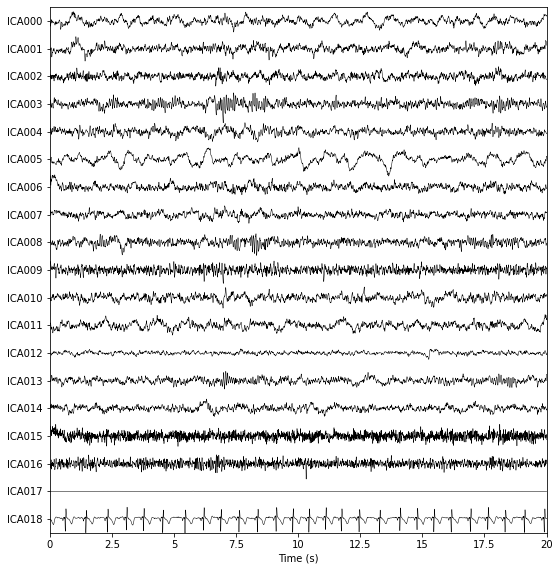

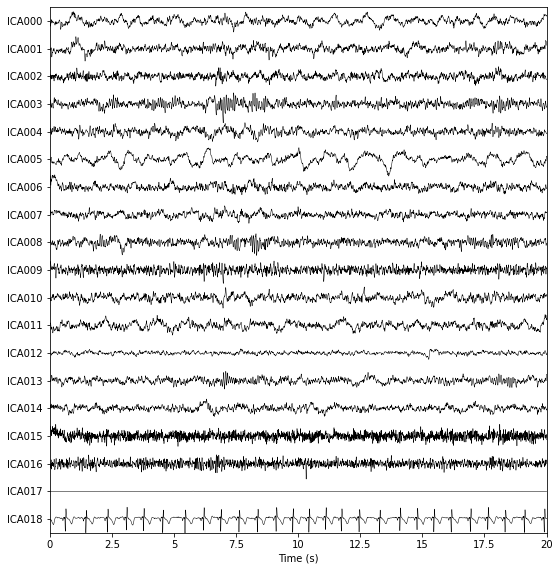

In [ ]:
raw.load_data()
ica.plot_sources(raw, show_scrollbars=False)

На рисунке ниже довольно ясно видно, что первый компонент (ICA000) достаточно хорошо улавливает сигнал EOG, а второй компонент (ICA001) очень похож на график ЭКГ.<br><br>
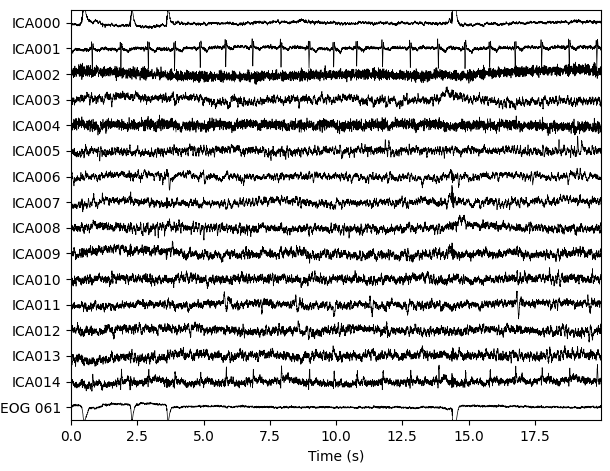

Используя метод `plot_components`, можно визуализировать топографическое распределение каждого выделенного компонента и увидеть его локализацию на поверхности головы. Локализация источника сигнала является одиним из ориентиров при принятии решения, следует ли считать конкретный сигнал артефактным. В энцефалографии существует теория объемного проведения, согласно которой сигналы с разных каналов ЭЭГ коррелируют между собой, поэтому очень точная локализация источника сигнала в пределах одного электрода свидетельствует, вероятнее всего, об его артефактном происхождении.
Так на основе топографических карт на рисунке ниже, можно сделать предположение, что компонент ICA000 является моргательным артефактом, поскольку имеет точную локализацию во фронтальной области головы.

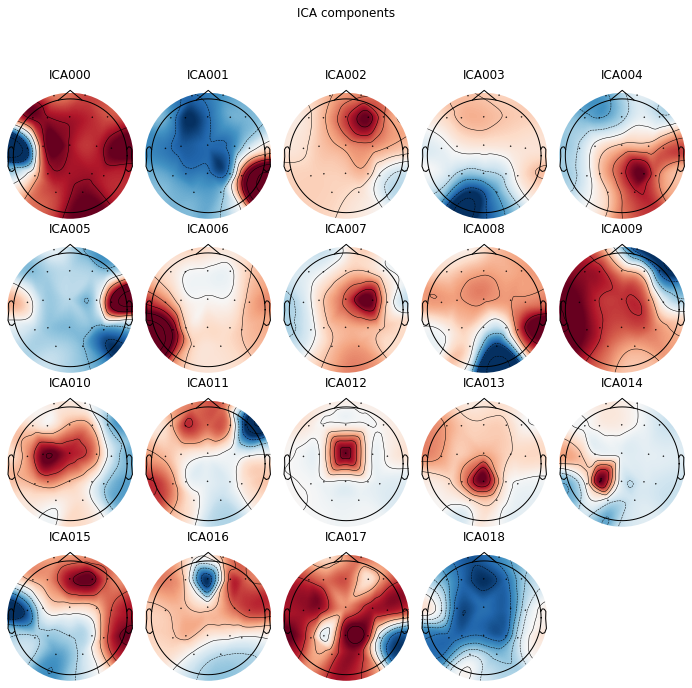

[<MNEFigure size 702x696.24 with 19 Axes>]

In [ ]:
ica.plot_components()

Топографические карты позволяют сделать предположение, какие из выделенных компонент соответствуют артефактным сигналам. Чтобы убедиться в этом, в MNE-Python есть дополнительные способы визуализации. Во-первых, используя метод `plot_overlay`, можно построить наложение исходного сигнала на восстановленный сигнал с исключением тех компонент, которые предположительно являются артефактными. Параметр `exclude` принимает список исключаемых компонент. В данном примере кроме нулевой компоненты следует исключить и первую, т.к. на рисунке выше было видно, что она соответствует артефактному сигналу ЭКГ.

Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 7 ICA components
    Projecting back using 19 PCA components


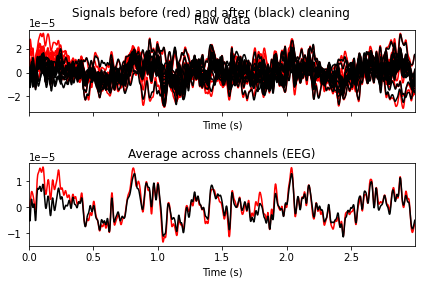

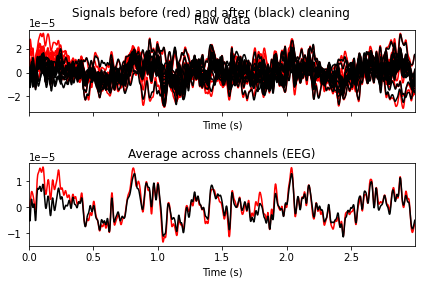

In [ ]:
ica.plot_overlay(raw, exclude=[6, 7, 12, 13, 14, 17, 18])

Красный график соответствует исходному сигналу, черная кривая - это сигнал после удаления компоненты, предположительно соответствующей артефактному источнику. В исходной записи можно наблюдать довольно сильно выраженные моргательные артефакты, которые в очищенной записи отсутствуют.

Для сравнения можно построить подобные графики, исключив большее число компонент, и проверить, приведет ли это к улучшению качества сигнала. Если к существенным улучшениям исключение большого количества компонент не приводит, лучше ограничиться исключением меньшего числа компонент, чтобы не потерять полезный сигнал.

Можно также построить некоторую диагностику каждой выделенной компоненты с помощью метода `plot_properties`.

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
91 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
91 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
91 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
91 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
91 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
91 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
91 matching events found
No baseline correction applied
0 projection items activated


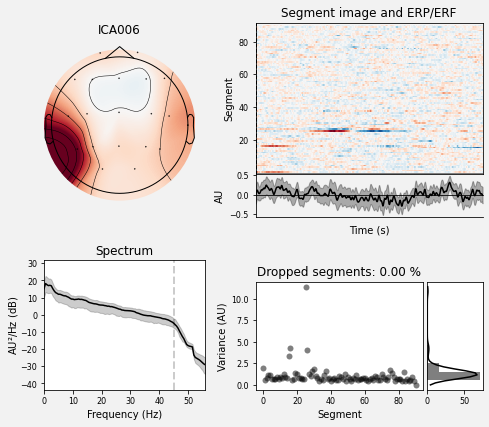

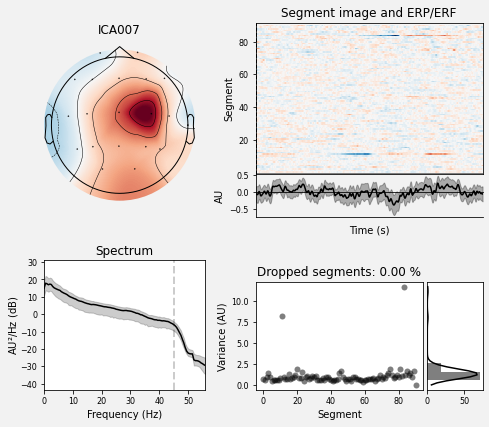

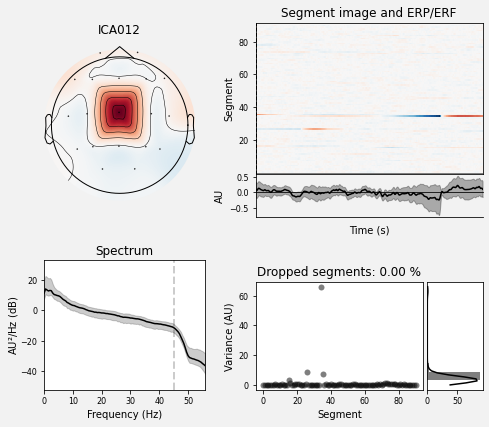

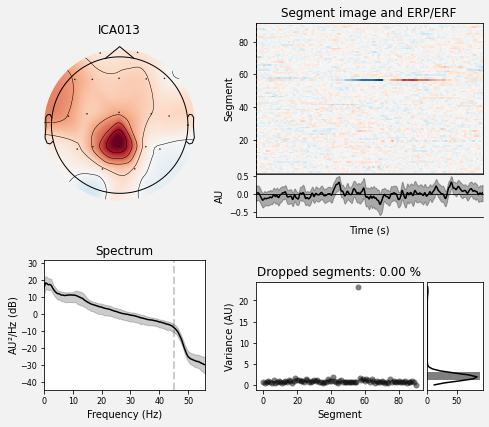

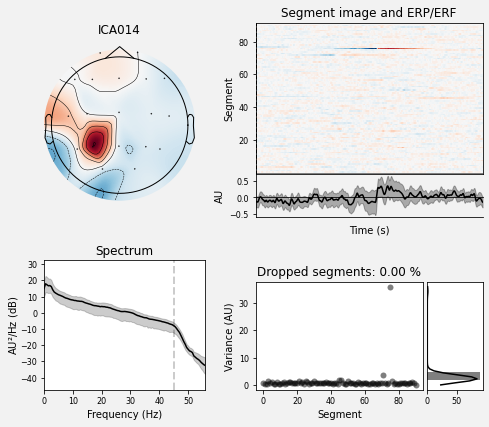

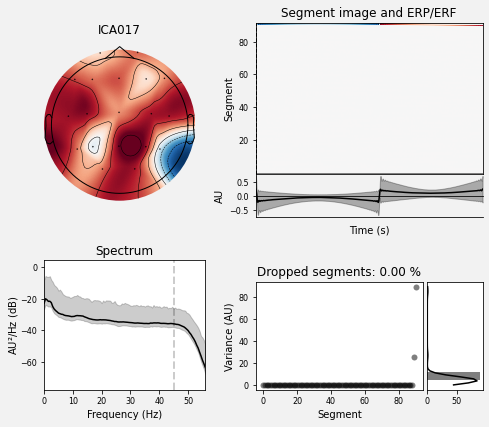

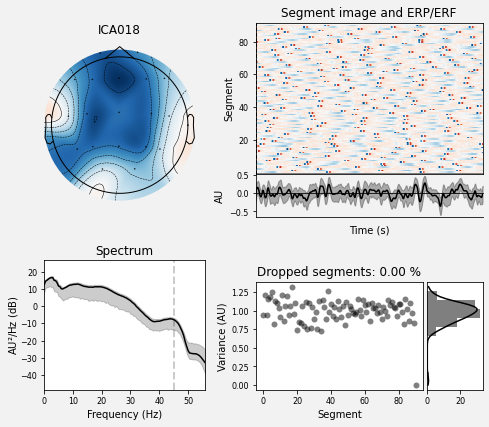

[<Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>]

In [ ]:
ica.plot_properties(raw, picks=[6, 7, 12, 13, 14, 17, 18])

После проведения визуального анализа и определения, какие компоненты следует исключить, их можно указать вручную, установив атрибут `ica.exclude`. Эта операция не удаляет компоненты из сигнала сразу, а только формирует список исключаемых компонент.

In [ ]:
ica.exclude = [6, 7, 12, 13, 14, 17, 18]

После этого можно восстановить исходные сигналы с удаленными артефактами с помощью метода `apply`.<br/>
Решение, полученное методом ICA на отфильтрованных данных, применяется к нефильтрованному сигналу. Поскольку `ica.apply()` изменяет данные in-place, рекомендуется сделать его копию.

In [ ]:
reconst_raw = raw.copy()
ica.apply(reconst_raw)

Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 7 ICA components
    Projecting back using 19 PCA components


<RawEDF | Subject35_1.edf, 19 x 91000 (182.0 s), ~13.2 MB, data loaded>

Чтобы наглядно проиллюстрировать коррекцию артефактов, можно просто построить вместе графики исходных необработанных и восстановленных данных.

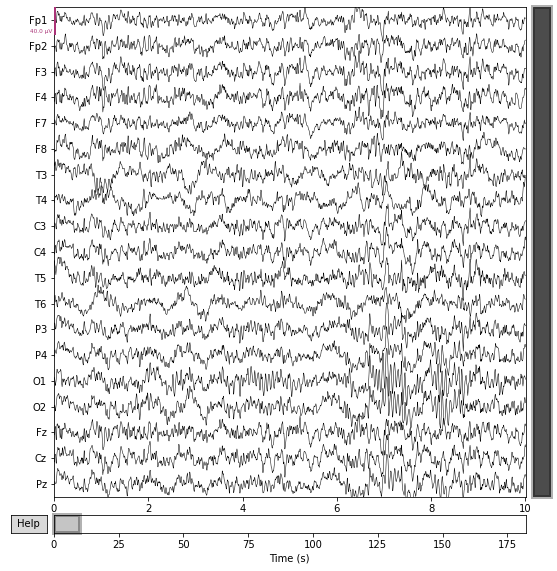

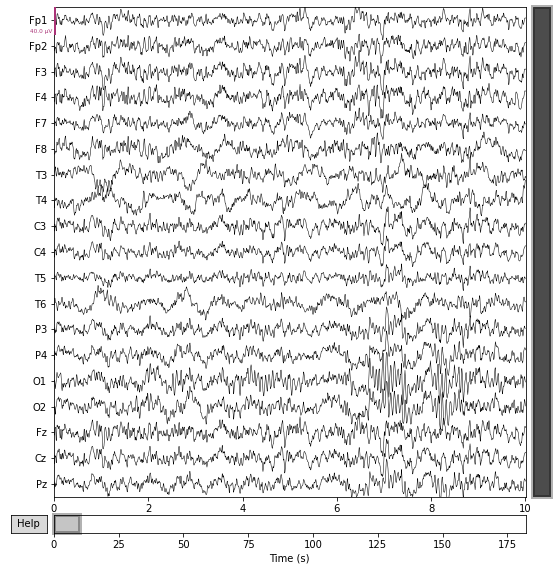

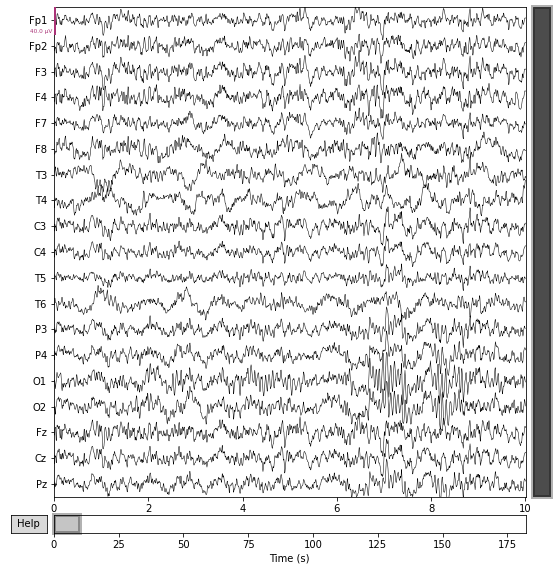

In [ ]:
raw.plot()
reconst_raw.plot()

**Оценка функционального состояния/Functional state assessment**<br/>
Оценка функционального состояния в определенные моменты времени (расслабленное состояние, состояние напряженной умственной деятельности и т.д.) может быть произведена по преобладанию тех или иных ритмов в общем сигнале ЭЭГ.<br/> Для этого, в частности, может быть использован метод на основе глобального поля мощности (GFP).<br/>
Пример применения данного метода: https://mne.tools/stable/auto_examples/time_frequency/time_frequency_global_field_power.html?highlight=alpha%20beta%20gamma



In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import mne
from mne.baseline import rescale
from mne.stats import bootstrap_confidence_interval

In [ ]:
# let's explore some frequency bands
iter_freqs = [
    ('Theta', 4, 7),
    ('Alpha', 8, 12),
    ('Beta', 13, 25),
    ('Gamma', 30, 45)
]
baseline = None

frequency_map = list()

for band, fmin, fmax in iter_freqs:
    # bandpass filter
    raw.filter(fmin, fmax, n_jobs=None,  # use more jobs to speed up.
               l_trans_bandwidth=1,  # make sure filter params are the same
               h_trans_bandwidth=1)  # in each band and skip "auto" option.

    # epoch
    epochs = mne.Epochs(raw, events, event_id=1, tmin=-0.2, tmax=0.5, baseline=baseline,
                        preload=True)
    # remove evoked response
    epochs.subtract_evoked()

    # get analytic signal (envelope)
    epochs.apply_hilbert(envelope=True)
    frequency_map.append(((band, fmin, fmax), epochs.average()))

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 3.50 Hz)
- Upper passband edge: 7.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 7.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Not setting metadata
91 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 91 events and 351 original time points ...
1 bad epochs dropped
Subtracting Evoked from Epochs
[done]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Win

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.1s finished


- Lower passband edge: 8.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 7.50 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 12.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Not setting metadata
91 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 91 events and 351 original time points ...
1 bad epochs dropped
Subtracting Evoked from Epochs
[done]
Filtering raw data in 1 contiguous segment


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.1s finished


Setting up band-pass filter from 13 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 12.50 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 25.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Not setting metadata
91 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 91 events and 351 original time points ...
1 bad epochs dropped
Subtracting Evoked from Epochs
[done]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.1s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 30 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 29.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 45.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Not setting metadata
91 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 91 events and 351 original time points ...
1 bad epochs dropped
Subtracting Evoked from Epochs
[done]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.1s finished


Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


Text(0.5, 0, 'Time [ms]')

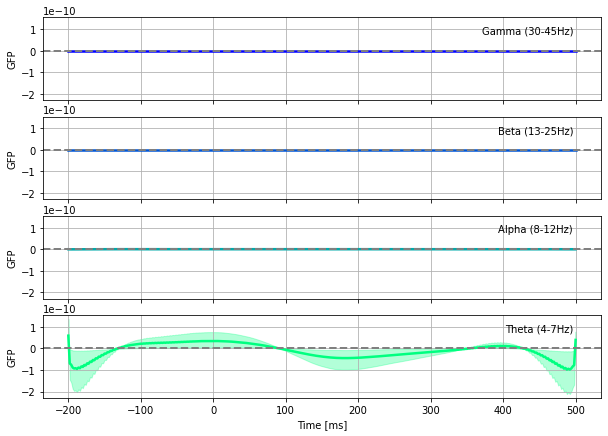

In [ ]:
def stat_fun(x):
    """Return sum of squares."""
    return np.sum(x ** 2, axis=0)


# Plot
fig, axes = plt.subplots(4, 1, figsize=(10, 7), sharex=True, sharey=True)
colors = plt.colormaps['winter_r'](np.linspace(0, 1, 4))
for ((freq_name, fmin, fmax), average), color, ax in zip(
        frequency_map, colors, axes.ravel()[::-1]):
    times = average.times * 1e3
    gfp = np.sum(average.data ** 2, axis=0)
    gfp = mne.baseline.rescale(gfp, times, baseline=(None, 0))
    ax.plot(times, gfp, label=freq_name, color=color, linewidth=2.5)
    ax.axhline(0, linestyle='--', color='grey', linewidth=2)
    ci_low, ci_up = bootstrap_confidence_interval(average.data, random_state=0,
                                                  stat_fun=stat_fun)
    ci_low = rescale(ci_low, average.times, baseline=(None, 0))
    ci_up = rescale(ci_up, average.times, baseline=(None, 0))
    ax.fill_between(times, gfp + ci_up, gfp - ci_low, color=color, alpha=0.3)
    ax.grid(True)
    ax.set_ylabel('GFP')
    ax.annotate('%s (%d-%dHz)' % (freq_name, fmin, fmax),
                xy=(0.95, 0.8),
                horizontalalignment='right',
                xycoords='axes fraction')
    # ax.set_xlim(-1000, 3000)

axes.ravel()[-1].set_xlabel('Time [ms]')

Преобладает theta - ритм, который связан с поисковым поведением и сосредоточением. Усиливается при эмоциональном напряжении.


Theta dominates - the rhythm, which is associated with search behavior and concentration. Increases with emotional stress.